In [3]:
"""  Crash Data Analysis

This notebook analyzes car crash data to identify trends in crashes caused by bad weather and poor illumination. The analysis consists of the following steps:

1. Load the crash data from the `crash_info_general.csv` file.
2. Add columns to the dataset to label crashes with bad weather and poor illumination.
3. Convert the CRASH_YEAR and CRASH_MONTH columns to a single datetime column, 'crash_date'.
4. Group the data by crash_date, bad_weather, and bad_illumination, and count the number of crashes for each group.
5. Merge the crash counts with the total crashes to obtain the crash ratio, i.e., the proportion of crashes with bad weather and/or poor illumination to the total number of crashes.
6. Filter the dataset to include only the crashes with bad weather, poor illumination, or both.
7. Sort the filtered data by crash_date.
8. Display the results, showing the crash_date, bad_weather, bad_illumination, and crash_ratio columns.

Todo:
    * ML our way to a risk score over the next time frame given the illumination and weather conditions on that day 
    (e.g.) if it's raining and dark, what is the risk score for the next 2 hours?
    * Identify the most dangerous streets in the city given each condition
    * Determine how much we need to spend on lighting and road maintenance to reduce the risk score by X amount, like 10% in the next 5 years


With this information, we can identify trends in crashes caused by bad weather and poor illumination over time and suggest improvements to reduce their occurrence. 

"""


"  Crash Data Analysis\n\nThis notebook analyzes car crash data to identify trends in crashes caused by bad weather and poor illumination. The analysis consists of the following steps:\n\n1. Load the crash data from the `crash_info_general.csv` file.\n2. Add columns to the dataset to label crashes with bad weather and poor illumination.\n3. Convert the CRASH_YEAR and CRASH_MONTH columns to a single datetime column, 'crash_date'.\n4. Group the data by crash_date, bad_weather, and bad_illumination, and count the number of crashes for each group.\n5. Merge the crash counts with the total crashes to obtain the crash ratio, i.e., the proportion of crashes with bad weather and/or poor illumination to the total number of crashes.\n6. Filter the dataset to include only the crashes with bad weather, poor illumination, or both.\n7. Sort the filtered data by crash_date.\n8. Display the results, showing the crash_date, bad_weather, bad_illumination, and crash_ratio columns.\n\nTodo:\n    * ML our 

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.plugins import HeatMap


In [5]:
data = pd.read_csv('./APAC_2023_Datasets/Crashes/crash_info_general.csv')
philly_map = gpd.read_file("./Boundaries_District/Boundaries_District.shp")

# Create a geodataframe from the dataset
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['DEC_LONG'], data['DEC_LAT']))

# Load the hourly weather data
hourly_weather_data = pd.read_csv('./APAC_2023_Datasets/Traffic, Investigations _ Other/hourly_weather_philadelphia.csv')

# Convert 'datetime' column to pandas datetime object
hourly_weather_data['datetime'] = pd.to_datetime(hourly_weather_data['datetime'])


FileNotFoundError: [Errno 2] No such file or directory: './APAC_2023_Datasets/Crashes/crash_info_general.csv'

In [ ]:
# %%
# Create GeoSpatial DataFrame
crashes_coords = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['DEC_LONG'], data['DEC_LAT'])
)

# %%
# Map to district
crashes_coords['DISTRICT_'] = ''
for idx in range(philly_map.shape[0]):
    pip = crashes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crashes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']
  

# %%
#Filter out invalid cases that do not fall within the districts
crashes_coords = crashes_coords[crashes_coords['DISTRICT_'] != '']

# %%
#Group by district and count
stats = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

In [ ]:
def get_two_sigma_value(column):
    mean = column.mean()
    std = column.std()
    two_sigma = 2 * std + mean

    return two_sigma

In [ ]:
## Data processing 

wind_speed_boundary = get_two_sigma_value(hourly_weather_data['avg_wind_speed'])
print(wind_speed_boundary)

def poor_weather_condition(row):
    if (row['precipitation'] > 0) or (row['snow_depth'] > 0) or (row['avg_wind_speed'] > wind_speed_boundary):
        return 1
    else:
        return 0

# Define a function to categorize illumination as poor or not based on sunshine
def poor_illumination_condition(row):
    if row['total_sunshine'] == 0:
        return 1
    else:
        return 0

# Create binary columns for poor forecasted weather and poor forecasted illumination
hourly_weather_data['poor_forecast_weather'] = hourly_weather_data.apply(poor_weather_condition, axis=1)
hourly_weather_data['poor_forecast_illumination'] = hourly_weather_data.apply(poor_illumination_condition, axis=1)

# Set the forecast_data DataFrame to the processed hourly_weather_data DataFrame
forecast_data = hourly_weather_data


# Create binary columns for poor weather and poor illumination
data['poor_weather'] = data['WEATHER1'].apply(lambda x: 1 if x not in [3, 4] else 0)
data['poor_illumination'] = data['ILLUMINATION'].apply(lambda x: 1 if x not in [1, 3] else 0)

# Update the geodataframe with the new columns
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['DEC_LONG'], data['DEC_LAT']))

31.518519727797557


In [ ]:
# Create binary columns for poor weather and poor illumination
crashes_coords['poor_weather'] = crashes_coords['WEATHER1'].apply(lambda x: 1 if x not in [3, 4] else 0)
crashes_coords['poor_illumination'] = crashes_coords['ILLUMINATION'].apply(lambda x: 1 if x not in [1, 3] else 0)

# Update the geodataframe with the new columns
new_gdf = gpd.GeoDataFrame(crashes_coords, geometry=gpd.points_from_xy(crashes_coords['DEC_LONG'], crashes_coords['DEC_LAT']))

# Aggregate the statistics for each district
stats_poor_weather = crashes_coords.groupby(['DISTRICT_'])[['poor_weather']].sum()
stats_poor_illumination = crashes_coords.groupby(['DISTRICT_'])[['poor_illumination']].sum()

# Merge the aggregated data back into the philly_map
map_and_stats_weather = philly_map.merge(stats_poor_weather, on='DISTRICT_')
map_and_stats_illumination = philly_map.merge(stats_poor_illumination, on='DISTRICT_')

def generate_overlay_heatmap(map_data, column, map_title, color='Blues'):
    fig, ax = plt.subplots(1, figsize=(12,8))
    plt.xticks(rotation=90)
    map_data.plot(
        column=column,
        cmap=color,
        linewidth=0.4,
        ax=ax,
        edgecolor='.4',
        legend=True,
        legend_kwds={
            'label': f"{map_title}, 2010-2021",
            'orientation': 'horizontal',
            'shrink': 0.5,
            'aspect': 50
        }
    )
    map_data.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
    ax.axis('off')

    # plt.title(map_title, fontsize=20)
    plt.show()

# Generate the color-coded maps
# generate_overlay_heatmap(map_and_stats_weather, 'poor_weather', 'Poor Weather Crashes in Philadelphia')
#generate_overlay_heatmap(map_and_stats_illumination, 'poor_illumination', 'Poor Illumination Crashes in Philadelphia', 'YlOrBr')


In [ ]:
# %%
# Spatial join of crash data and district polygons
crashes_in_districts = gpd.sjoin(crashes_coords, philly_map, op='within', how='inner')

# %%
# Group crash data by district
crashes_by_district = crashes_in_districts.groupby(['DIST_NUM']).agg(
    total_crashes=('CRN', 'count'),
    poor_weather_crashes=('poor_weather', 'sum'),
    poor_illumination_crashes=('poor_illumination', 'sum')
)

# Calculate crash ratios for poor weather and poor illumination
crashes_by_district['poor_weather_ratio'] = crashes_by_district['poor_weather_crashes'] / crashes_by_district['total_crashes']
crashes_by_district['poor_illumination_ratio'] = crashes_by_district['poor_illumination_crashes'] / crashes_by_district['total_crashes']

# Rank districts based on poor weather and poor illumination ratios
riskiest_districts_weather = crashes_by_district.sort_values('poor_weather_ratio', ascending=False)
riskiest_districts_illumination = crashes_by_district.sort_values('poor_illumination_ratio', ascending=False)

print("Riskiest districts based on poor weather:")
print(riskiest_districts_weather[['poor_weather_ratio']])
print("\nRiskiest districts based on poor illumination:")
print(riskiest_districts_illumination[['poor_illumination_ratio']])

riskiest_districts_illumination[['poor_illumination_ratio']].to_csv('riskiest_districts_illumination.csv')
riskiest_districts_weather[['poor_weather_ratio']].to_csv('riskiest_districts_weather.csv')


/Users/seeusim/opt/anaconda3/envs/philly-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/pc/n3qxl__51zq83lxk2mhxs1x00000gn/T/ipykernel_82265/3184266053.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  crashes_in_districts = gpd.sjoin(crashes_coords, philly_map, op='within', how='inner')


Riskiest districts based on poor weather:
          poor_weather_ratio
DIST_NUM                    
7                   0.218399
8                   0.210356
39                  0.209724
12                  0.209619
14                  0.204910
16                  0.190702
5                   0.187594
35                  0.183665
77                  0.181818
1                   0.177618
22                  0.172779
9                   0.172539
6                   0.170122
18                  0.167438
2                   0.164753
17                  0.163185
3                   0.161853
19                  0.160835
25                  0.159385
15                  0.154658
24                  0.154069
26                  0.153193

Riskiest districts based on poor illumination:
          poor_illumination_ratio
DIST_NUM                         
77                       0.113636
14                       0.067849
39                       0.067779
12                       0.063460
17        

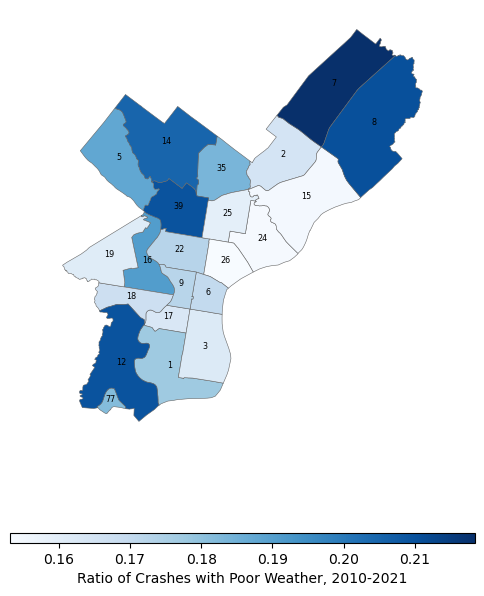

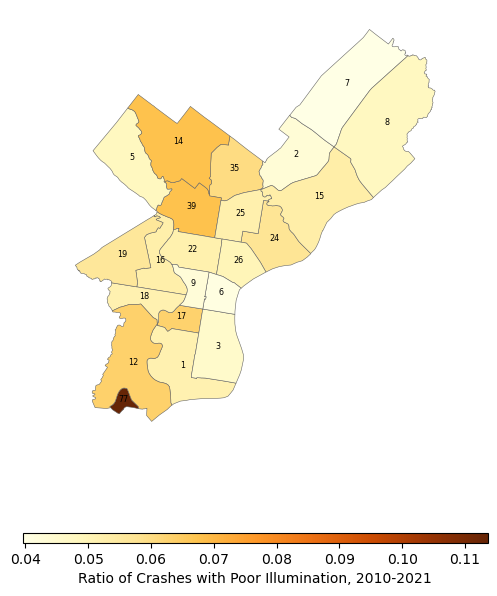

In [ ]:
generate_overlay_heatmap(philly_map.merge(crashes_by_district['poor_weather_ratio'], on='DIST_NUM'), 'poor_weather_ratio', 'Ratio of Crashes with Poor Weather')
generate_overlay_heatmap(philly_map.merge(crashes_by_district['poor_illumination_ratio'], on='DIST_NUM'), 'poor_illumination_ratio', 'Ratio of Crashes with Poor Illumination', color='YlOrBr')

In [ ]:
### Rank the districts by worst weather and illumination

# Aggregate the data by district
agg_data = crashes_in_districts.groupby("DIST_NUM").agg(
    good_weather_count=("WEATHER1", lambda x: (x == 0).sum()),
    bad_weather_count=("WEATHER1", lambda x: (x != 0).sum()),
    bad_illumination_count=("ILLUMINATION", lambda x: (x != 1).sum()),
    total_crashes=("CRN", "count")
)

# Calculate the proportion of bad weather, bad illumination, etc., per district
agg_data["bad_weather_ratio"] = agg_data["bad_weather_count"] / (agg_data["good_weather_count"] + agg_data["bad_weather_count"])
agg_data["bad_illumination_ratio"] = agg_data["bad_illumination_count"] / (agg_data["good_weather_count"] + agg_data["bad_weather_count"])

# Sort districts by bad weather ratio, feel free to remove the .head() to see the full list
worst_weather_districts = agg_data.sort_values("bad_weather_ratio", ascending=False)
print("Top districts with the worst weather:")
print(worst_weather_districts)

# Sort districts by bad illumination ratio, same as above. 
worst_illumination_districts = agg_data.sort_values("bad_illumination_ratio", ascending=False)
print("\nTop districts with the worst illumination:")
print(worst_illumination_districts[["bad_illumination_ratio"]])


Top districts with the worst weather:
          good_weather_count  bad_weather_count  bad_illumination_count   
DIST_NUM                                                                  
1                          0               3333                    1395  \
2                          0               6270                    2388   
39                         0               6890                    3100   
35                         0               7089                    3031   
26                         0               5183                    2104   
25                         0               7485                    3132   
24                         0               6893                    2795   
22                         0               6135                    2372   
19                         0               4887                    1963   
18                         0               7567                    3205   
17                         0               2537               

# Visual Heatmaps

Using Folium, we generated the following interactive, visual maps.

In [6]:
# Function to generate a heatmap based on a specific column
def generate_heatmap(column, map_title):
    philly_lat, philly_long = 39.9526, -75.1652
    m = folium.Map(location=[philly_lat, philly_long], zoom_start=11)
    HeatMap(data=gdf[['DEC_LAT', 'DEC_LONG', column]].dropna(),
            min_opacity=0.5, radius=10, blur=15,
            max_zoom=1, gradient={0.2: 'blue', 0.5: 'lime', 1: 'red'}
           ).add_to(m)
    title_html = f'<h3 align="center" style="font-size:20px"><b>{map_title}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    return m

In [ ]:
# Create binary columns for poor weather and poor illumination
data['poor_weather'] = data['WEATHER1'].apply(lambda x: 1 if x not in [3, 4] else 0)
data['poor_illumination'] = data['ILLUMINATION'].apply(lambda x: 1 if x not in [1, 3] else 0)

# Update the geodataframe with the new columns
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['DEC_LONG'], data['DEC_LAT']))

In [ ]:
# Generate heatmaps for different variables based off Philadelphia map 
car_crash_density_map = generate_heatmap('CRN', 'Car Crash Density in Philadelphia')
poor_weather_map = generate_heatmap('poor_weather', 'Poor Weather Car Crashes in Philadelphia')
poor_illumination_map = generate_heatmap('poor_illumination', 'Poor Illumination Car Crashes in Philadelphia')

In [ ]:
# Display the heatmaps
car_crash_density_map.save('car_crash_density_map.html')
poor_weather_map.save('poor_weather_map.html')
poor_illumination_map.save('poor_illumination_map.html')